In [1]:
import pandas as pd
import numpy as np
import random
import os
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'NanumGothic' # 폰트 변경
plt.rcParams['axes.unicode_minus'] = False # 축 값 마이너스 깨짐 해결
from collections import defaultdict
from scipy import stats as stats
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import KFold
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

In [3]:
# 데이터 불러오기
# pd.read_csv() 함수를 사용해서 데이터를 읽어오는 코드입니다.
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

# 데이터를 확인하기 위해 head() 함수를 사용합니다.
train.head(5)

,ID,나이,키(cm),몸무게(kg),BMI,시력,충치,공복 혈당,혈압,중성 지방,혈청 크레아티닌,콜레스테롤,고밀도지단백,저밀도지단백,헤모글로빈,요 단백,간 효소율,label
0,TRAIN_0000,35,170,70,24.22,1.10,1,98,40,80,1.3,211,75,120,15.9,1,1.53,1
1,TRAIN_0001,40,150,55,24.44,1.00,0,173,39,104,0.6,251,46,184,11.8,1,1.45,0
2,TRAIN_0002,60,170,50,17.30,0.75,0,96,40,61,0.8,144,43,89,15.3,1,1.04,0
3,TRAIN_0003,40,150,45,20.00,0.50,0,92,40,46,0.7,178,66,110,13.4,1,1.18,0
4,TRAIN_0004,55,155,65,27.06,1.00,0,87,42,95,0.9,232,62,151,13.8,1,1.32,0


In [4]:
train.columns

Index(['ID', '나이', '키(cm)', '몸무게(kg)', 'BMI', '시력', '충치', '공복 혈당', '혈압',
       '중성 지방', '혈청 크레아티닌', '콜레스테롤', '고밀도지단백', '저밀도지단백', '헤모글로빈', '요 단백',
       '간 효소율', 'label'],
      dtype='object')

In [5]:
x_corr = train.drop(['ID'], axis = 1)

In [6]:
x_corr

,나이,키(cm),몸무게(kg),BMI,시력,충치,공복 혈당,혈압,중성 지방,혈청 크레아티닌,콜레스테롤,고밀도지단백,저밀도지단백,헤모글로빈,요 단백,간 효소율,label
0,35,170,70,24.22,1.10,1,98,40,80,1.3,211,75,120,15.9,1,1.53,1
1,40,150,55,24.44,1.00,0,173,39,104,0.6,251,46,184,11.8,1,1.45,0
2,60,170,50,17.30,0.75,0,96,40,61,0.8,144,43,89,15.3,1,1.04,0
3,40,150,45,20.00,0.50,0,92,40,46,0.7,178,66,110,13.4,1,1.18,0
4,55,155,65,27.06,1.00,0,87,42,95,0.9,232,62,151,13.8,1,1.32,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,25,170,65,22.49,1.50,0,87,45,141,1.2,184,44,112,14.9,1,1.50,0
6996,60,165,65,23.88,0.90,0,87,45,82,0.9,184,64,103,14.3,1,1.47,1
6997,40,180,100,30.86,1.20,0,97,44,87,0.9,178,54,107,15.6,1,1.00,0
6998,60,150,55,24.44,0.60,0,89,57,161,0.6,157,49,76,14.4,1,1.00,0


<Axes: >

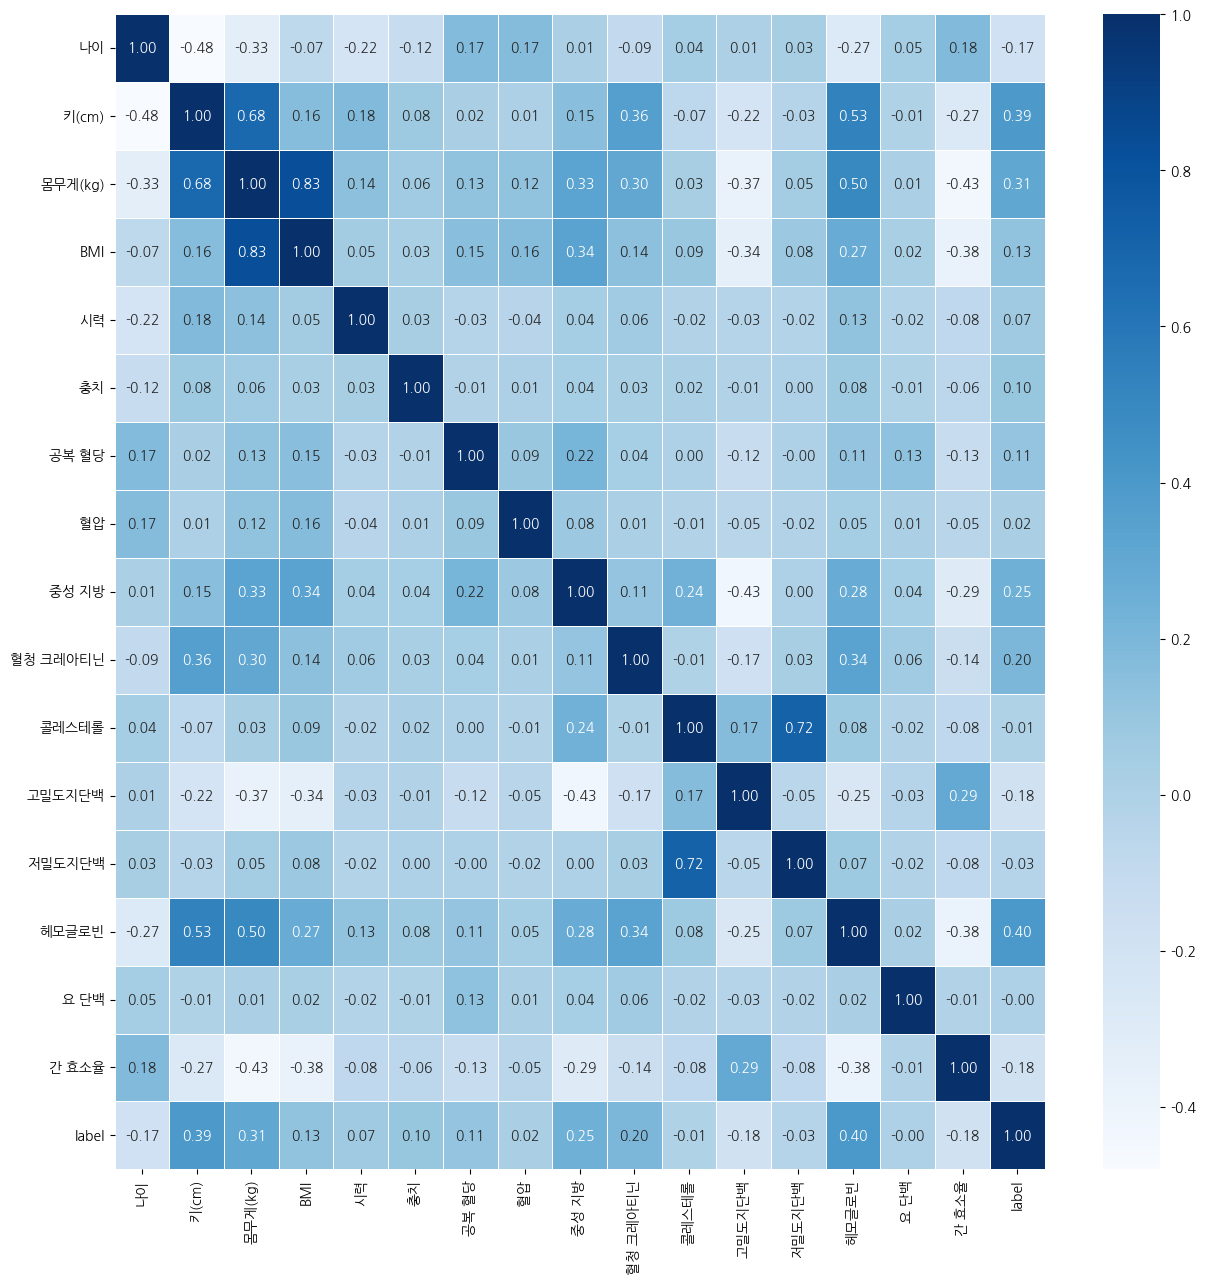

In [7]:
# 상관계수 시각화
plt.figure(figsize=(15,15))
sns.heatmap(data = x_corr.corr(), annot=True, fmt = '.2f', linewidths=.5, cmap='Blues')

In [8]:
# 'ID', 'label', '나이', '키(cm)', '몸무게(kg)', 'BMI'
# 'ID', '나이', '키(cm)', '몸무게(kg)', 'BMI'

In [9]:
x_train = train.drop(['ID', 'label', '키(cm)'], axis = 1)
y_train = train['label']

x_test = test.drop(['ID', '키(cm)'], axis = 1)

In [10]:
x_train.head()

,나이,몸무게(kg),BMI,시력,충치,공복 혈당,혈압,중성 지방,혈청 크레아티닌,콜레스테롤,고밀도지단백,저밀도지단백,헤모글로빈,요 단백,간 효소율
0,35,70,24.22,1.10,1,98,40,80,1.3,211,75,120,15.9,1,1.53
1,40,55,24.44,1.00,0,173,39,104,0.6,251,46,184,11.8,1,1.45
2,60,50,17.30,0.75,0,96,40,61,0.8,144,43,89,15.3,1,1.04
3,40,45,20.00,0.50,0,92,40,46,0.7,178,66,110,13.4,1,1.18
4,55,65,27.06,1.00,0,87,42,95,0.9,232,62,151,13.8,1,1.32


In [11]:
x_train.tail()

,나이,몸무게(kg),BMI,시력,충치,공복 혈당,혈압,중성 지방,혈청 크레아티닌,콜레스테롤,고밀도지단백,저밀도지단백,헤모글로빈,요 단백,간 효소율
6995,25,65,22.49,1.50,0,87,45,141,1.2,184,44,112,14.9,1,1.50
6996,60,65,23.88,0.90,0,87,45,82,0.9,184,64,103,14.3,1,1.47
6997,40,100,30.86,1.20,0,97,44,87,0.9,178,54,107,15.6,1,1.00
6998,60,55,24.44,0.60,0,89,57,161,0.6,157,49,76,14.4,1,1.00
6999,50,65,23.88,0.65,0,104,47,124,0.8,251,56,170,13.6,1,0.81


In [12]:
x_train.columns

Index(['나이', '몸무게(kg)', 'BMI', '시력', '충치', '공복 혈당', '혈압', '중성 지방', '혈청 크레아티닌',
       '콜레스테롤', '고밀도지단백', '저밀도지단백', '헤모글로빈', '요 단백', '간 효소율'],
      dtype='object')

In [13]:
# 칼럼 데이터 타입 확인
for col in x_train.columns:
    data_type = x_train[f'{col}'].dtype
    print(f'{col}: {data_type}')

나이: int64
몸무게(kg): int64
BMI: float64
시력: float64
충치: int64
공복 혈당: int64
혈압: int64
중성 지방: int64
혈청 크레아티닌: float64
콜레스테롤: int64
고밀도지단백: int64
저밀도지단백: int64
헤모글로빈: float64
요 단백: int64
간 효소율: float64


In [14]:
x_train.shape

(7000, 15)

1. 흡연하면 올라가는 수치 
* 충치, 혈당, 혈압, 중성지방, 혈청 크레아티닌, 저밀도지단백, 헤모글로빈, 요단백, 
2. 흡연하면 내려가는 수치 
* 콜레스테롤, 시력, 고밀도지단백, 간 효소율

In [15]:
# 수치형 변수의 분포 확인
x_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
나이,7000.0,43.973571,12.063793,20.00,35.00,40.00,50.00,85.00
몸무게(kg),7000.0,65.932857,12.978702,30.00,55.00,65.00,75.00,130.00
BMI,7000.0,24.144423,3.501945,14.27,21.60,23.88,26.12,42.45
시력,7000.0,1.011650,0.427828,0.10,0.80,1.00,1.20,9.90
충치,7000.0,0.227429,0.419202,0.00,0.00,0.00,0.00,1.00
공복 혈당,7000.0,99.331857,21.129670,57.00,89.00,96.00,104.00,386.00
혈압,7000.0,45.532857,8.820611,14.00,40.00,45.00,50.00,91.00
중성 지방,7000.0,127.144714,73.918492,21.00,74.00,107.00,161.00,999.00
혈청 크레아티닌,7000.0,0.884900,0.241523,0.10,0.80,0.90,1.00,10.00
콜레스테롤,7000.0,197.276571,36.306494,86.00,173.00,195.00,219.00,395.00


In [16]:
# 결측치 개수 파악
x_train.isnull().sum()

나이          0
몸무게(kg)     0
BMI         0
시력          0
충치          0
공복 혈당       0
혈압          0
중성 지방       0
혈청 크레아티닌    0
콜레스테롤       0
고밀도지단백      0
저밀도지단백      0
헤모글로빈       0
요 단백        0
간 효소율       0
dtype: int64

In [17]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   나이        7000 non-null   int64  
 1   몸무게(kg)   7000 non-null   int64  
 2   BMI       7000 non-null   float64
 3   시력        7000 non-null   float64
 4   충치        7000 non-null   int64  
 5   공복 혈당     7000 non-null   int64  
 6   혈압        7000 non-null   int64  
 7   중성 지방     7000 non-null   int64  
 8   혈청 크레아티닌  7000 non-null   float64
 9   콜레스테롤     7000 non-null   int64  
 10  고밀도지단백    7000 non-null   int64  
 11  저밀도지단백    7000 non-null   int64  
 12  헤모글로빈     7000 non-null   float64
 13  요 단백      7000 non-null   int64  
 14  간 효소율     7000 non-null   float64
dtypes: float64(5), int64(10)
memory usage: 820.4 KB


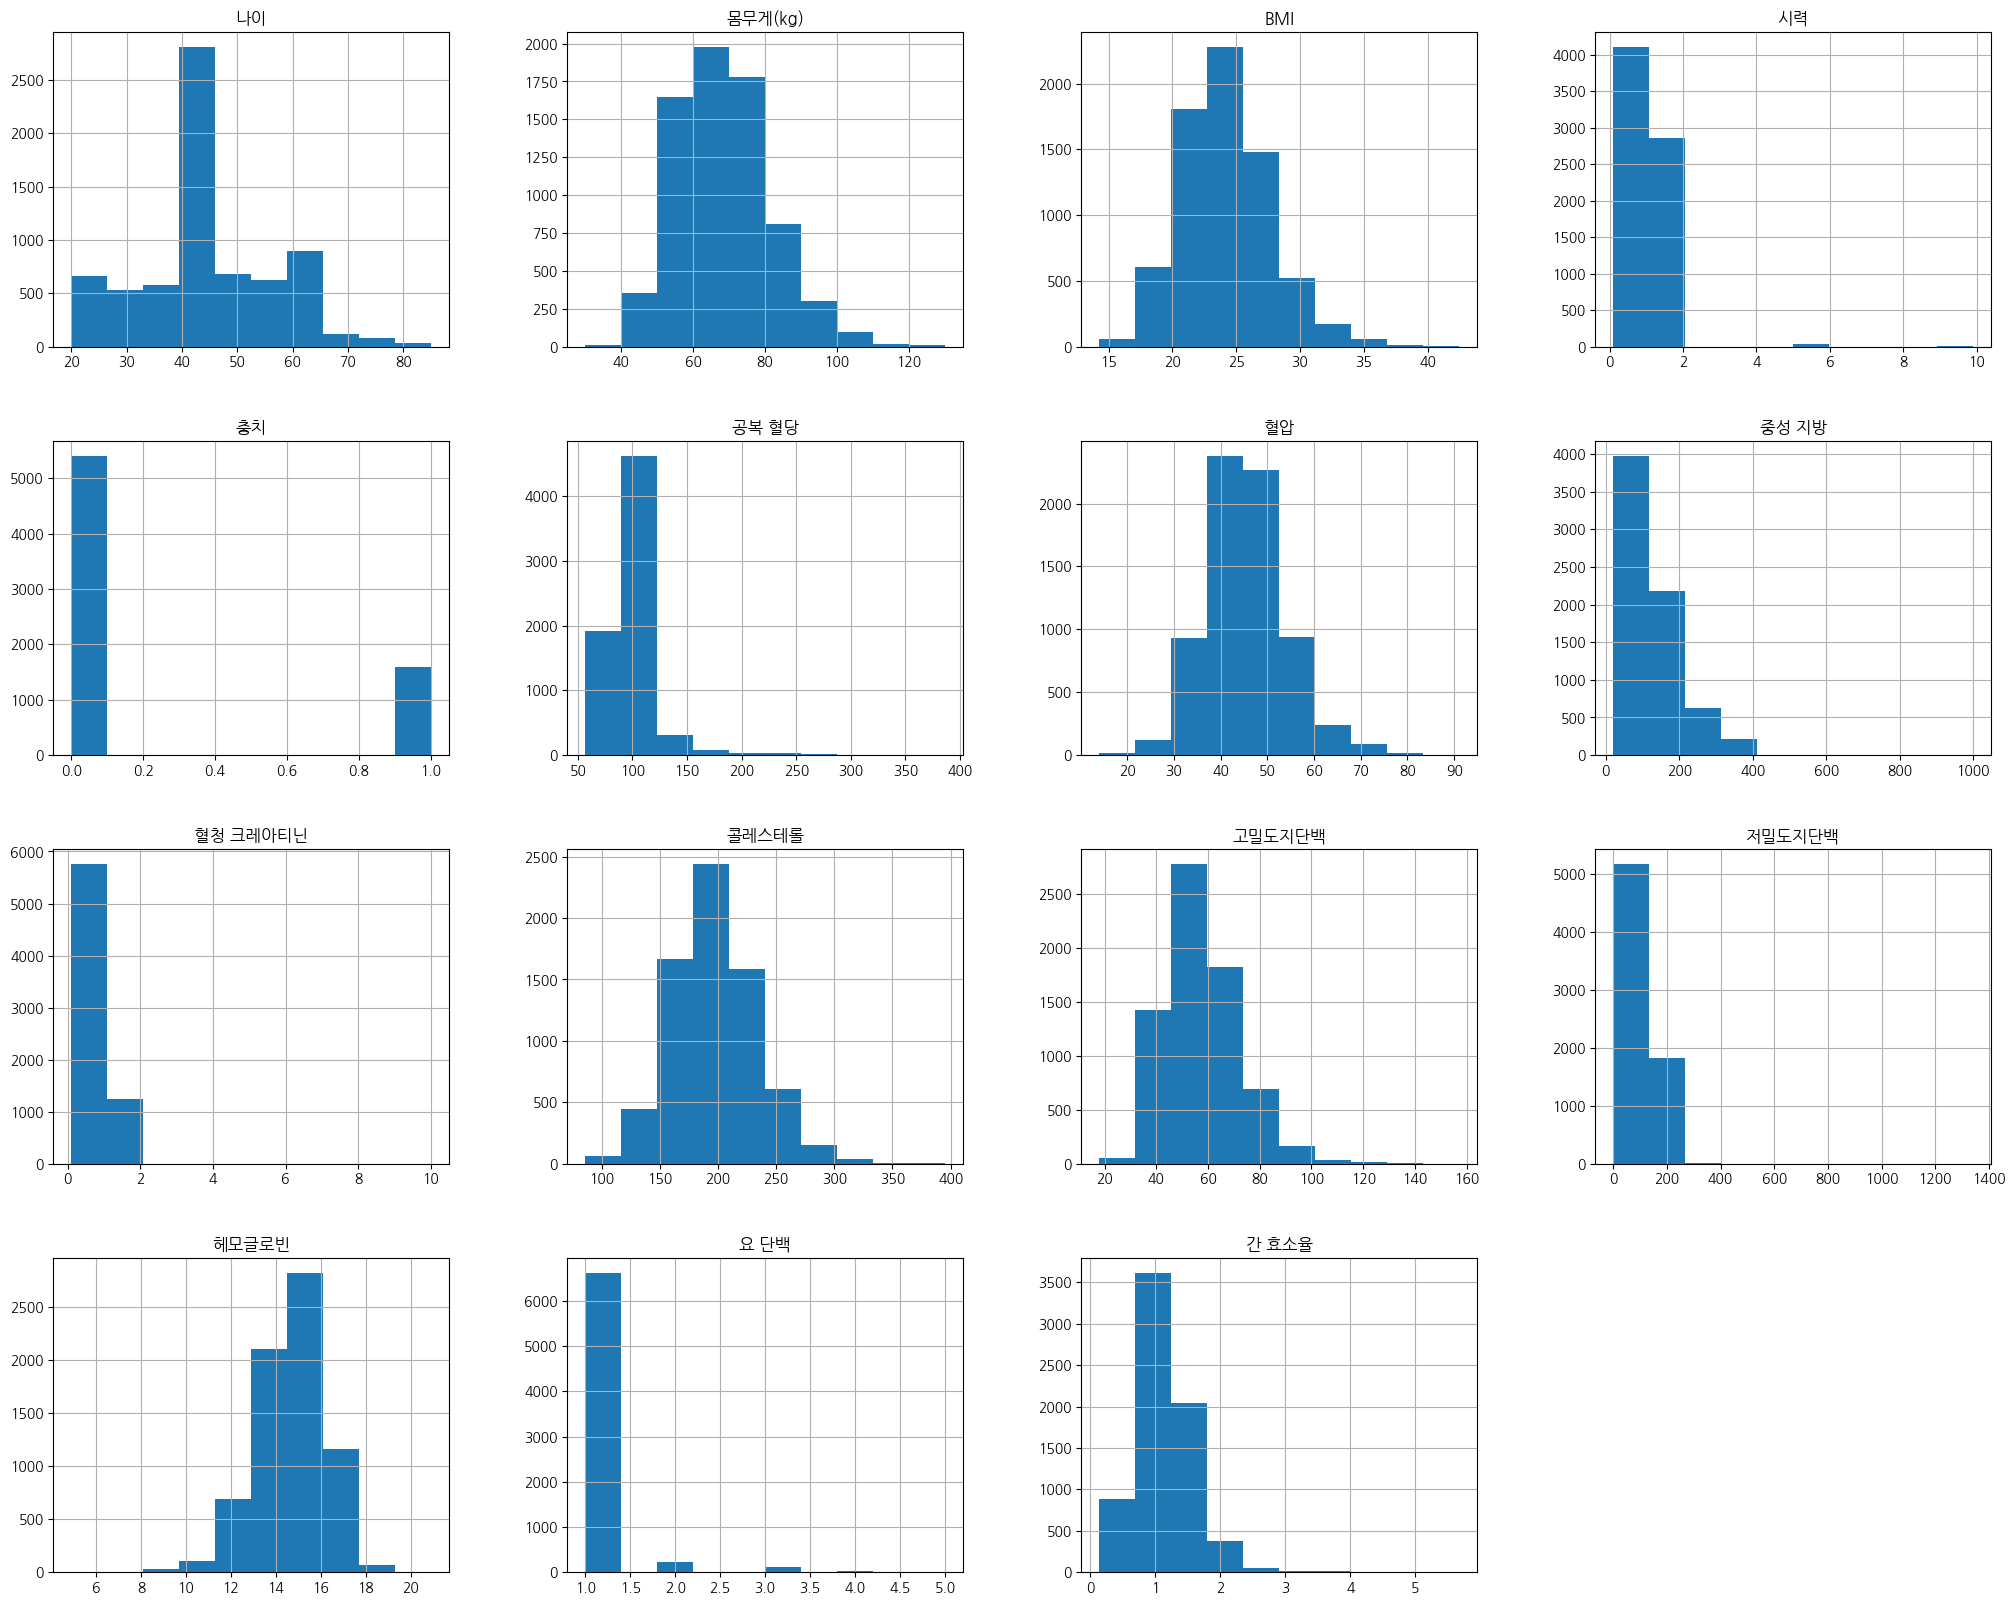

In [18]:
# 변수 분포 시각화
x_train.hist(figsize=(25,20))
plt.show()

<Axes: >

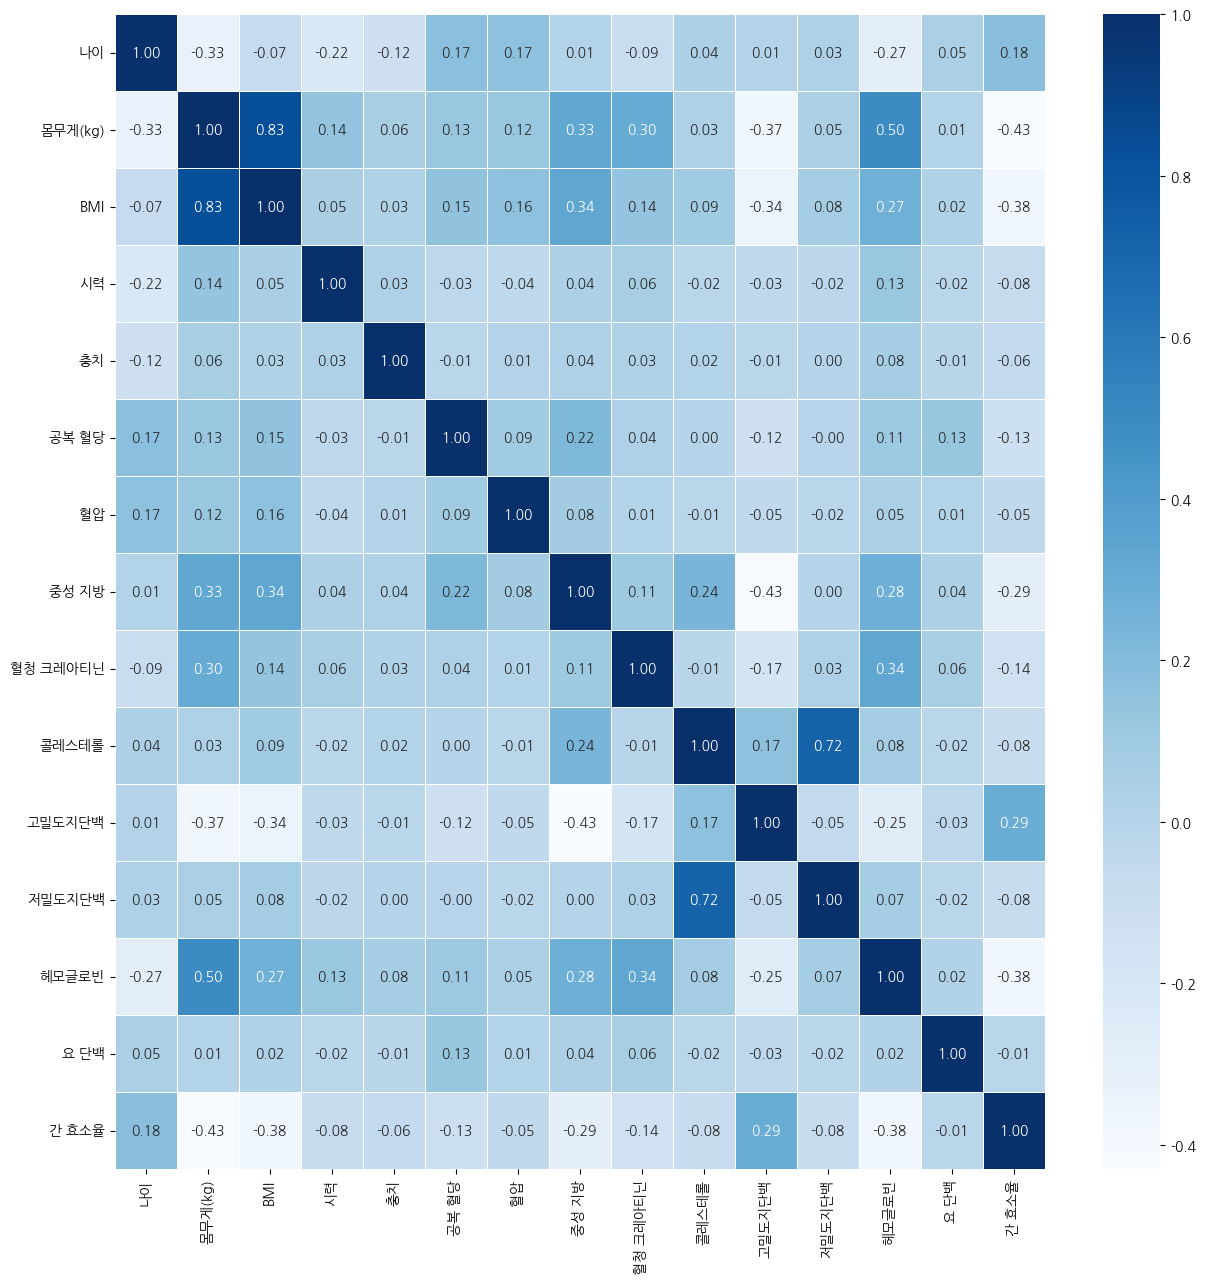

In [19]:
# 상관계수 시각화
plt.figure(figsize=(15,15))
sns.heatmap(data = x_train.corr(), annot=True, fmt = '.2f', linewidths=.5, cmap='Blues')

In [20]:
def create_submission(model, x_test):
    pred = model.predict(x_test)
    submit = pd.read_csv('data/sample_submission.csv')
    # 예측한 값을 TARGET 컬럼에 할당합니다.
    submit['label'] = pred
    submit.head()
    # 예측한 결과를 파일로 저장합니다. index 인자의 값을 False로 설정하지 않으면 제출이 정상적으로 진행되지 않습니다.
    now = datetime.datetime.now()
    time_now = now.strftime('%Y-%m-%d_%H-%M-%S') 
    submit.to_csv(f'results/{str(model)}_submission_{str(time_now)}.csv', index = False)

In [21]:
# 스케일러 적용
scaler = MinMaxScaler()
scaler = scaler.fit(x_train)

# 훈련 데이터에 스케일러 적용
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [22]:
def run(x_train, x_test, model):
    print(f'Model = {model}')

    kfold = KFold(n_splits=3, shuffle=True)
    model_kf_acc = []

    n_iter = 0
    for train_idx, valid_idx in kfold.split(x_train):
        X_train_, X_valid_ = x_train[train_idx], x_train[valid_idx]
        y_train_, y_valid_ = y_train[train_idx], y_train[valid_idx]
        
        # 훈련
        model.fit(X_train_, y_train_)
        model_pred = model.predict(X_valid_)
        model_acc = accuracy_score(model_pred, y_valid_)
        n_iter += 1
        model_kf_acc.append([n_iter, model_acc, model])
        print(f'KFold {n_iter} 교차검증 정확도 : {model_acc}, 학습 데이터 크기:{X_train_.shape[0]}, 검증 데이터 크기:{y_train_.shape[0]}')

    model_kf_acc_sort = model_kf_acc
    model_kf_acc_sort.sort(key=lambda x : x[1], reverse=True)
    # KFold 검증 후 가장 정확도가 높은 모델 선택
    model = model_kf_acc_sort[0][2]
    print(f'교차검증 중 가장 높은 정확도  : KFold {model_kf_acc_sort[0][0]}, {model_kf_acc_sort[0][1]}\n')
    
    # create_submission(model, x_test)
    
    return model_kf_acc

In [23]:
models = [
    DecisionTreeClassifier(),
    RandomForestClassifier(random_state=42),
    AdaBoostClassifier(random_state=42),
    SVC(random_state=42),
    SGDClassifier(random_state=42),
    LogisticRegression(random_state=42),
]

In [24]:
results = defaultdict(list)
max_acc = 0
final_model = None

for model in models:
    model_kf_acc = run(x_train, x_test, model=model)
    for i, result in enumerate(model_kf_acc):
        results[f'{str(result[2])}'].append(str(result[1]))
        if result[1] >= max_acc:
            max_acc = result[1]
            final_model = result[2]
        
create_submission(final_model, x_test)

# 모든 Fold 별 결과 확인
total_fold_df = pd.DataFrame(results, index=['Fold1', 'Fold2', 'Fold3'])
total_fold_df

Model = DecisionTreeClassifier()
KFold 1 교차검증 정확도 : 0.6473864610111397, 학습 데이터 크기:4666, 검증 데이터 크기:4666
KFold 2 교차검증 정확도 : 0.6789541363051864, 학습 데이터 크기:4667, 검증 데이터 크기:4667
KFold 3 교차검증 정확도 : 0.6660951564509215, 학습 데이터 크기:4667, 검증 데이터 크기:4667
교차검증 중 가장 높은 정확도  : KFold 2, 0.6789541363051864

Model = RandomForestClassifier(random_state=42)
KFold 1 교차검증 정확도 : 0.7270779777206512, 학습 데이터 크기:4666, 검증 데이터 크기:4666
KFold 2 교차검증 정확도 : 0.7213887698242606, 학습 데이터 크기:4667, 검증 데이터 크기:4667
KFold 3 교차검증 정확도 : 0.7111015859408487, 학습 데이터 크기:4667, 검증 데이터 크기:4667
교차검증 중 가장 높은 정확도  : KFold 1, 0.7270779777206512

Model = AdaBoostClassifier(random_state=42)
KFold 1 교차검증 정확도 : 0.713796058269066, 학습 데이터 크기:4666, 검증 데이터 크기:4666
KFold 2 교차검증 정확도 : 0.7149592798971282, 학습 데이터 크기:4667, 검증 데이터 크기:4667
KFold 3 교차검증 정확도 : 0.7046720960137163, 학습 데이터 크기:4667, 검증 데이터 크기:4667
교차검증 중 가장 높은 정확도  : KFold 2, 0.7149592798971282

Model = SVC(random_state=42)
KFold 1 교차검증 정확도 : 0.7146529562982005, 학습 데이터 크기:4666, 검증 데이터 크기:4666


,DecisionTreeClassifier(),RandomForestClassifier(random_state=42),AdaBoostClassifier(random_state=42),SVC(random_state=42),SGDClassifier(random_state=42),LogisticRegression(random_state=42)
Fold1,0.6789541363051864,0.7270779777206512,0.7149592798971282,0.730390055722246,0.7132447492498929,0.7123874839262752
Fold2,0.6660951564509215,0.7213887698242606,0.713796058269066,0.7146529562982005,0.7102443206172311,0.7051007286755251
Fold3,0.6473864610111397,0.7111015859408487,0.7046720960137163,0.7085297899699957,0.7005141388174807,0.6915167095115681
